# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

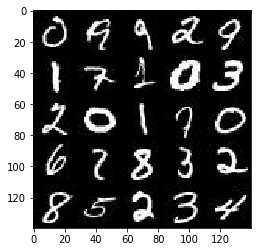

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

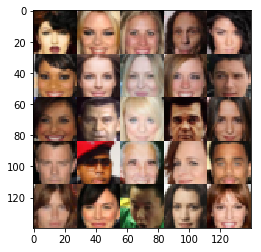

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(dtype = tf.float32, shape = (None, image_width, image_height, image_channels),
                                 name = 'real_images')
    #print (image_width, image_height, image_channels)
    
    z_input = tf.placeholder(dtype = tf.float32, shape = (None, z_dim), name = 'z_input')
    learing_rate = tf.placeholder(dtype = tf.float32, shape = None, name = 'lr')

    return real_images, z_input, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leakyRelu(x, reuse = False, leak = 0.2, name = 'lrelu'):
    #with tf.variable_scope(name, reuse):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # With a wave of my wand, I generate . . . MAGIC NUMBERS! WHAM-BAM-ALAKAZAM
        d1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        relu1 = leakyRelu(d1)
        #print(relu1.get_shape().as_list())
        
        d2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(d2, training = True)
        relu2 = leakyRelu(bn2)
        #print(relu2.get_shape().as_list())
        
        d3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(d3, training = True)
        relu3 = leakyRelu(bn3)
        #print(relu3.get_shape().as_list())
        
        d4 = tf.layers.conv2d(relu3, 512, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(d4, training = True)
        relu4 = leakyRelu(bn4)
        #print(relu4.get_shape().as_list())
        
        
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1, 
                                kernel_initializer = tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2 
    
    # Alright Mr. Forums-guy, I'll try that, but it can't possibly be righ- oh fark me.
    with tf.variable_scope('generator', reuse = not is_train) as scope:
        # WHA-FLA-ABRACADABRA
        l1 = tf.layers.dense(z, 7*7*512)
        
        l1 = tf.reshape(l1, (-1, 7, 7, 512))
        l1 = tf.layers.batch_normalization(l1, training = is_train)
        l1 = leakyRelu(l1)
        #print(l1.get_shape().as_list())
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 5, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training = is_train)
        l2 = leakyRelu(l2)
        #print(l2.get_shape().as_list())
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training = is_train)
        l3 = leakyRelu(l3)
        #print(l3.get_shape().as_list())
        
        #l4 = tf.layers.conv2d_transpose(l3, 128, 5, strides = 1, padding = 'same', 
        #                               kernel_initializer = tf.contrib.layers.xavier_initializer())
        #l4 = tf.layers.batch_normalization(l4, training = is_train)
        #l4 = tf.maximum(alpha * l4, l4)
        #print(l4.get_shape().as_list())
        
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides = 1, padding = 'same', 
                                           kernel_initializer = tf.contrib.layers.xavier_initializer())
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen, reuse = True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_real, 
                                                labels = tf.ones_like(dis_model_real) * np.random.uniform(0.7, 1.2)))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.zeros_like(dis_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.ones_like(dis_model_fake)))
    
    dis_loss = dis_loss_fake + dis_loss_real
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    

    # Book keeping
    print_every, show_every = 10, 100    
    _, image_width, image_height, image_channels = data_shape
    steps = 0
    losses = []
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                noize = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: noize})
                sess.run(g_opt, feed_dict = {input_z: noize, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = sess.run(d_loss, feed_dict = {input_real: batch_images, input_z: noize})
                    train_loss_g = g_loss.eval({input_z: noize})
                    
                    print('Epoch {}/{}...'.format(epoch_i + 1, epochs),
                            'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                            'Generator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    # gen_samples = sess.run(
                    #               generator(input_z, image_channels, reuse = True, training = False),
                    #               feed_dict = {input_z: sample_z})
                    # samples.append(gen_samples)
                                 
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
            # show final each epoch
            show_generator_output(sess, 36, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.2135... Generator Loss: 17.7698
Epoch 1/2... Discriminator Loss: -0.1656... Generator Loss: 9.2553
Epoch 1/2... Discriminator Loss: -0.1920... Generator Loss: 9.9749
Epoch 1/2... Discriminator Loss: -0.2197... Generator Loss: 6.5657
Epoch 1/2... Discriminator Loss: -0.0175... Generator Loss: 3.1630
Epoch 1/2... Discriminator Loss: -0.2429... Generator Loss: 4.4462
Epoch 1/2... Discriminator Loss: 3.4768... Generator Loss: 0.2300
Epoch 1/2... Discriminator Loss: 1.5461... Generator Loss: 0.4062
Epoch 1/2... Discriminator Loss: 1.7805... Generator Loss: 0.2623
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.5222


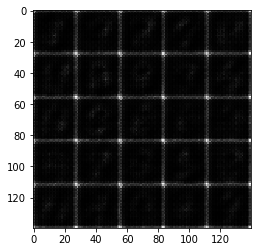

Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 0.8008
Epoch 1/2... Discriminator Loss: 1.8001... Generator Loss: 1.4816
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.8960
Epoch 1/2... Discriminator Loss: 1.6122... Generator Loss: 0.2813
Epoch 1/2... Discriminator Loss: 1.6848... Generator Loss: 0.2530
Epoch 1/2... Discriminator Loss: 1.6056... Generator Loss: 0.2812
Epoch 1/2... Discriminator Loss: 1.5466... Generator Loss: 0.2895
Epoch 1/2... Discriminator Loss: 1.5567... Generator Loss: 0.4907
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.4489


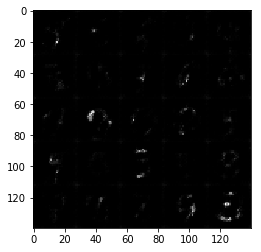

Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.3581
Epoch 1/2... Discriminator Loss: 1.8801... Generator Loss: 0.1836
Epoch 1/2... Discriminator Loss: 1.5361... Generator Loss: 0.3284
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.5126
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 0.3179
Epoch 1/2... Discriminator Loss: 2.5841... Generator Loss: 0.0837
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 1.7122... Generator Loss: 0.2334
Epoch 1/2... Discriminator Loss: 1.9237... Generator Loss: 0.2063
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.4865


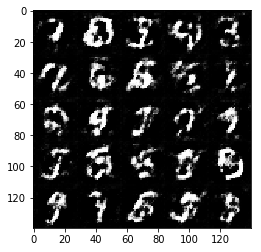

Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 0.5575
Epoch 1/2... Discriminator Loss: 1.5241... Generator Loss: 0.3162
Epoch 1/2... Discriminator Loss: 1.9303... Generator Loss: 0.2073
Epoch 1/2... Discriminator Loss: 2.1242... Generator Loss: 0.1486
Epoch 1/2... Discriminator Loss: 1.8436... Generator Loss: 0.2540
Epoch 1/2... Discriminator Loss: 1.8510... Generator Loss: 0.2209
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 1.6502
Epoch 1/2... Discriminator Loss: 1.5298... Generator Loss: 0.2947
Epoch 1/2... Discriminator Loss: 2.2804... Generator Loss: 0.1356
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.5096


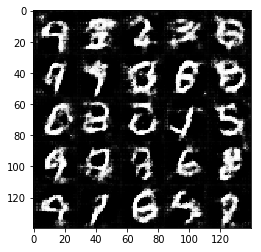

Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.3259
Epoch 1/2... Discriminator Loss: 2.1077... Generator Loss: 0.1500
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 2.2222... Generator Loss: 0.1494
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 1.1384
Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 0.9753... Generator Loss: 0.8171


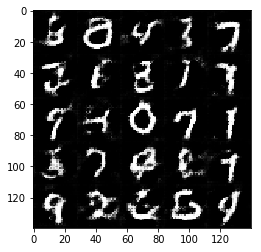

Epoch 1/2... Discriminator Loss: 1.5935... Generator Loss: 0.2897
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.4766
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.6682
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.2555
Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 1.2234
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.3481
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 2.6390... Generator Loss: 0.0952
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.4372


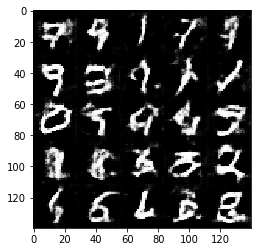

Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 2.7685
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.3519
Epoch 1/2... Discriminator Loss: 0.8211... Generator Loss: 1.1902
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 0.5651
Epoch 1/2... Discriminator Loss: 1.8122... Generator Loss: 0.2113
Epoch 1/2... Discriminator Loss: 0.8517... Generator Loss: 0.8554
Epoch 1/2... Discriminator Loss: 1.5751... Generator Loss: 3.0820
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.4500
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 0.7256


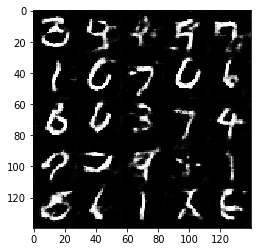

Epoch 1/2... Discriminator Loss: 1.5679... Generator Loss: 0.2937
Epoch 1/2... Discriminator Loss: 1.6463... Generator Loss: 0.2509
Epoch 1/2... Discriminator Loss: 1.6136... Generator Loss: 0.3202
Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 2.6959... Generator Loss: 0.0919
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 2.4327... Generator Loss: 3.0770
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.4761


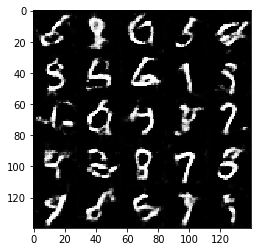

Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 0.5042... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 2.3369
Epoch 1/2... Discriminator Loss: 2.8073... Generator Loss: 0.0763
Epoch 1/2... Discriminator Loss: 1.5716... Generator Loss: 0.3655
Epoch 1/2... Discriminator Loss: 1.8686... Generator Loss: 0.3113
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 0.5507
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.4324
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 0.6137
Epoch 1/2... Discriminator Loss: 2.7061... Generator Loss: 0.1091


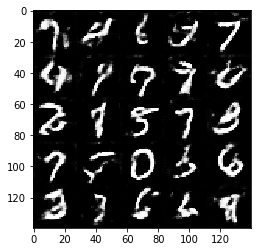

Epoch 1/2... Discriminator Loss: 1.7129... Generator Loss: 0.2744
Epoch 1/2... Discriminator Loss: 1.0814... Generator Loss: 0.5104
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 0.6335


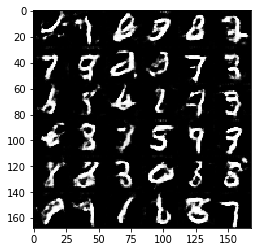

Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.4296
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.3455
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.0357
Epoch 2/2... Discriminator Loss: 1.7079... Generator Loss: 0.5074
Epoch 2/2... Discriminator Loss: 2.6891... Generator Loss: 0.0837


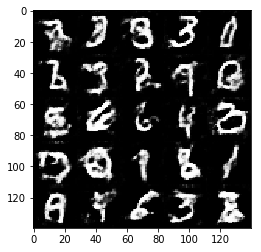

Epoch 2/2... Discriminator Loss: 1.7067... Generator Loss: 0.2456
Epoch 2/2... Discriminator Loss: 1.5410... Generator Loss: 0.2982
Epoch 2/2... Discriminator Loss: 1.9120... Generator Loss: 0.1963
Epoch 2/2... Discriminator Loss: 2.4659... Generator Loss: 3.0404
Epoch 2/2... Discriminator Loss: 1.9084... Generator Loss: 0.1995
Epoch 2/2... Discriminator Loss: 2.8609... Generator Loss: 0.0864
Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 0.5059
Epoch 2/2... Discriminator Loss: 2.5309... Generator Loss: 0.2184
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.0913


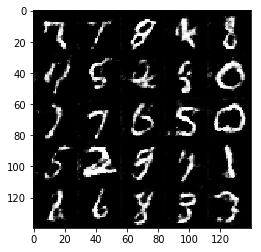

Epoch 2/2... Discriminator Loss: 2.0342... Generator Loss: 0.2412
Epoch 2/2... Discriminator Loss: 2.7193... Generator Loss: 0.1057
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 2.5677... Generator Loss: 0.1024
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.3979
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.4341
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 3.0705
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 0.3740
Epoch 2/2... Discriminator Loss: 1.8656... Generator Loss: 0.2184
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 0.3253


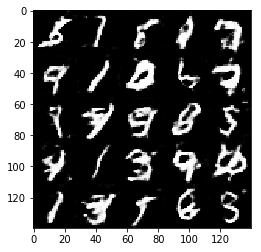

Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.4192
Epoch 2/2... Discriminator Loss: 1.6736... Generator Loss: 0.2686
Epoch 2/2... Discriminator Loss: 2.2621... Generator Loss: 0.1480
Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 0.3665
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.4169
Epoch 2/2... Discriminator Loss: 0.7891... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.7558... Generator Loss: 0.2683
Epoch 2/2... Discriminator Loss: 1.5644... Generator Loss: 0.2795
Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 0.3343


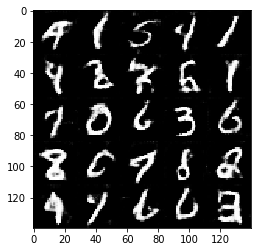

Epoch 2/2... Discriminator Loss: 1.0626... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 2.0736... Generator Loss: 0.1962
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 0.6544
Epoch 2/2... Discriminator Loss: 0.7540... Generator Loss: 0.7143
Epoch 2/2... Discriminator Loss: 2.4274... Generator Loss: 0.1190
Epoch 2/2... Discriminator Loss: 2.2112... Generator Loss: 3.9172
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.2223
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.4316
Epoch 2/2... Discriminator Loss: 1.6194... Generator Loss: 0.2627
Epoch 2/2... Discriminator Loss: 0.6231... Generator Loss: 1.1176


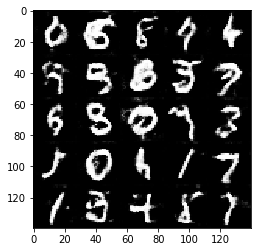

Epoch 2/2... Discriminator Loss: 0.5286... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 0.4391... Generator Loss: 1.2276
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 1.4789
Epoch 2/2... Discriminator Loss: 2.2613... Generator Loss: 0.4753
Epoch 2/2... Discriminator Loss: 1.5640... Generator Loss: 0.2822
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 0.6618
Epoch 2/2... Discriminator Loss: 2.5820... Generator Loss: 0.1069
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.3999
Epoch 2/2... Discriminator Loss: 1.0970... Generator Loss: 0.4675
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 2.2825


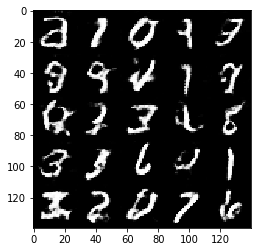

Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 1.2614
Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 3.9742
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 0.5503
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 0.6137
Epoch 2/2... Discriminator Loss: 2.6952... Generator Loss: 0.0917
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 0.5222
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 0.8217... Generator Loss: 1.5292


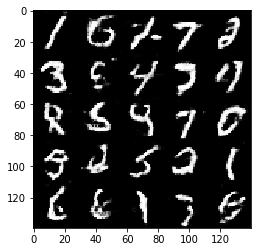

Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 1.0218
Epoch 2/2... Discriminator Loss: 1.4453... Generator Loss: 0.4732
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.4301
Epoch 2/2... Discriminator Loss: 1.1044... Generator Loss: 0.5139
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 2.8020... Generator Loss: 0.1023
Epoch 2/2... Discriminator Loss: 0.5300... Generator Loss: 1.5190
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 0.8533
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.4838


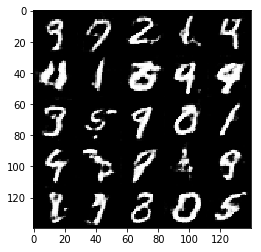

Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 1.5103
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 1.5350
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 0.5695
Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 1.5918
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 0.9670
Epoch 2/2... Discriminator Loss: 1.7249... Generator Loss: 0.2693
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 0.7393
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 1.0930
Epoch 2/2... Discriminator Loss: 3.2717... Generator Loss: 0.0732


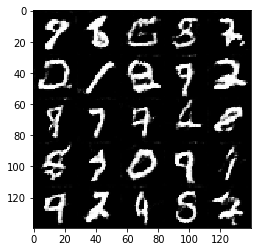

Epoch 2/2... Discriminator Loss: 1.8310... Generator Loss: 0.2254
Epoch 2/2... Discriminator Loss: 1.7676... Generator Loss: 0.2279
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 0.8640
Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 0.4605
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 0.5025
Epoch 2/2... Discriminator Loss: 2.0801... Generator Loss: 0.3066


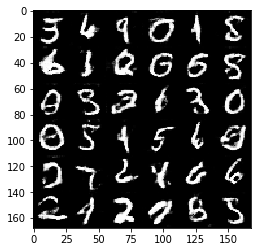

In [13]:
batch_size = 64
z_dim = 200 # was 64
learning_rate = 0.0002
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2323... Generator Loss: 0.2710
Epoch 1/1... Discriminator Loss: 2.1739... Generator Loss: 0.3022
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 2.2268
Epoch 1/1... Discriminator Loss: 1.9830... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 2.7703... Generator Loss: 5.1922
Epoch 1/1... Discriminator Loss: 1.6865... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 2.3886... Generator Loss: 0.2380
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.3531
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 2.5959


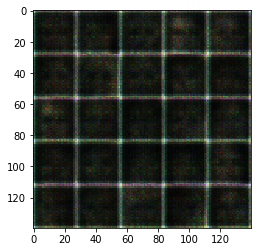

Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 2.7076
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.3602
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 2.3753
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 2.5106
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.0789


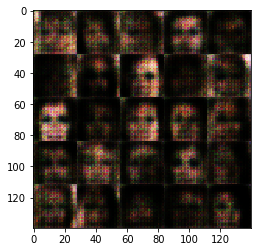

Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.6870
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.5767
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 2.0646
Epoch 1/1... Discriminator Loss: 2.4752... Generator Loss: 0.2027
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.2264
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.7195


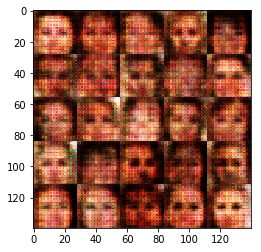

Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 3.5413
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 2.2804
Epoch 1/1... Discriminator Loss: 0.6630... Generator Loss: 2.7516
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.2726
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 1.6086
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 4.8868
Epoch 1/1... Discriminator Loss: 1.6248... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6439


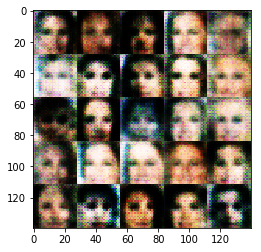

Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 3.8480
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 2.4253
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 4.1675
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 3.3891
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 3.8284
Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 2.4188
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 4.3870
Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 3.0938


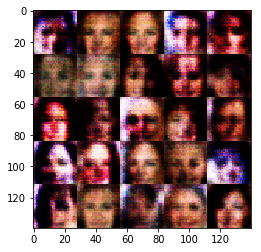

Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 3.9477
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 6.5576
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 3.4491
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 2.3729
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 2.1261
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 2.9028


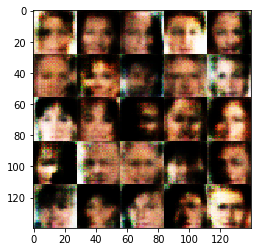

Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 2.6979
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 1.7525... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.7672
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 2.8243
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 5.8301
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 2.0885
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 3.6784


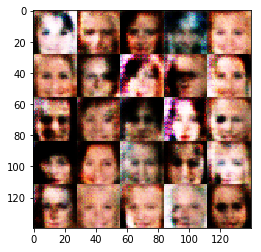

Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 2.5388
Epoch 1/1... Discriminator Loss: 2.8326... Generator Loss: 4.2018
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 2.0297
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 2.5066
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 4.3511
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 4.9322
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 4.4041
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.8744


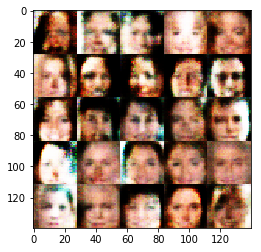

Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 3.6727
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 3.9126
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 3.1125
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 2.8937
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 1.7757... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 2.5443
Epoch 1/1... Discriminator Loss: 1.7274... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 3.5161
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.5834


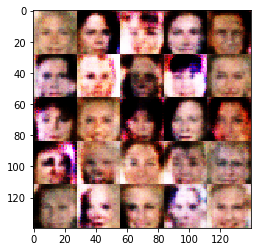

Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 2.2459
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 2.9863
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 5.0181
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 2.4310
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.6357
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 3.0756
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 3.9573
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.3554


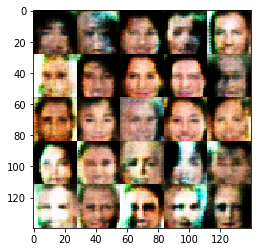

Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 4.1176
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 2.2386
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 2.3346
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 3.2802
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 3.3413
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.4368
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 2.8230
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 2.1197
Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 3.0467


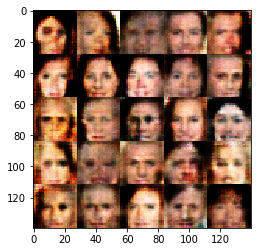

Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 5.9364
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 3.0076
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 4.0060
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 3.3605
Epoch 1/1... Discriminator Loss: 0.7322... Generator Loss: 2.2003
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 4.3035
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 3.8327
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 3.9350
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.9684


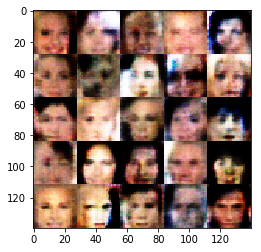

Epoch 1/1... Discriminator Loss: 0.6630... Generator Loss: 3.2817
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 6.0395
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 5.5661
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 2.5856
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 2.8970
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 3.1759
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 4.7105
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 4.1303


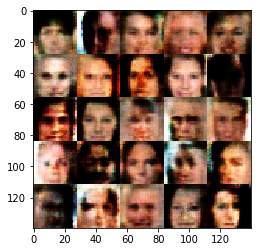

Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 2.9623
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.3947
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 4.3700
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 3.2354
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 3.9859
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 2.0173
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 2.9268
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 1.6271


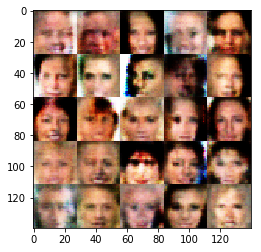

Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 2.8802
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.6720
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 5.3739
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 4.4125
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 2.6376
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.6055
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 3.1178
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 4.3721


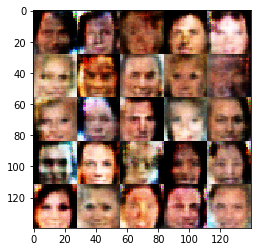

Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 3.0258
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 3.7504
Epoch 1/1... Discriminator Loss: 1.6378... Generator Loss: 1.5738
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 4.9641
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 4.2563
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 3.7464
Epoch 1/1... Discriminator Loss: 2.7159... Generator Loss: 3.9070
Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 2.2374
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.6688


In [ ]:
batch_size = 
z_dim = 200
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.